# Designing an Optimal Trade: Size, Leverage, and Execution

**A Calculus-Based Framework for Trading Decisions**

This notebook implements optimization techniques for three fundamental trading decisions: position sizing, leverage selection, and execution timing. These problems share a common mathematical structure that appears throughout quantitative finance.

## Overview

Every trading decision involves balancing competing forces. Trade too large and market impact destroys your edge. Use too much leverage and volatility wipes you out. Execute too fast and you pay excessive slippage. The key insight: **optimal solutions exist because benefits diminish while costs accelerate**.

### Mathematical Foundation

We solve three optimization problems:

**1. Trade Size Optimization**
$$\max_x \quad P(x) = \alpha x - \beta x^2 - cx$$

**2. Leverage Optimization (Kelly Criterion)**
$$\max_\ell \quad R(\ell) = \ell\mu - \frac{1}{2}\ell^2\sigma^2$$

**3. Execution Time Optimization**
$$\min_t \quad C(t) = \frac{k}{t} + \lambda t$$

Each has a closed-form solution derived from first-order conditions.

## 1. Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
np.set_printoptions(precision=4, suppress=True)

# Color palette
COLORS = {
    'primary': '#2ecc71',
    'secondary': '#3498db',
    'accent': '#e74c3c',
    'neutral': '#95a5a6',
}

print("Environment configured successfully.")
print(f"NumPy version: {np.__version__}")

Environment configured successfully.
NumPy version: 2.0.2


## 2. Trade Size Optimization

### The Problem

You've identified a trading opportunity with expected return $\alpha$ per share. However:
- **Market impact**: Trading moves prices against you, costing $\beta x^2$ (quadratic in size)
- **Transaction costs**: Fixed cost $c$ per share (commissions, spread)

The profit function is:

$$P(x) = \underbrace{\alpha x}_{\text{gross profit}} - \underbrace{\beta x^2}_{\text{market impact}} - \underbrace{cx}_{\text{transaction costs}}$$

### Deriving the Optimal Size

Taking the first derivative and setting to zero:

$$P'(x) = \alpha - 2\beta x - c = 0$$

Solving for $x$:

$$x^* = \frac{\alpha - c}{2\beta}$$

The second derivative confirms this is a maximum:

$$P''(x) = -2\beta < 0 \quad \text{(concave)}$$

In [2]:
def profit_function(x, alpha, beta, c):
    """
    Compute profit for a given trade size.
    
    P(x) = αx - βx² - cx
    
    Args:
        x: Trade size (shares)
        alpha: Expected return per share
        beta: Market impact coefficient
        c: Transaction cost per share
    
    Returns:
        Profit value
    """
    return alpha * x - beta * x**2 - c * x


def optimal_trade_size(alpha, beta, c):
    """
    Compute optimal trade size analytically.
    
    x* = (α - c) / (2β)
    """
    if alpha <= c:
        return 0  # No profitable trade exists
    return (alpha - c) / (2 * beta)


def analyze_trade_size(alpha, beta, c, name=""):
    """
    Complete analysis of trade size optimization.
    """
    x_opt = optimal_trade_size(alpha, beta, c)
    p_opt = profit_function(x_opt, alpha, beta, c)
    
    # Break-even points
    # P(x) = 0 => αx - βx² - cx = 0 => x(α - c - βx) = 0
    x_breakeven = (alpha - c) / beta if alpha > c else 0
    
    return {
        'name': name,
        'optimal_size': x_opt,
        'max_profit': p_opt,
        'breakeven_size': x_breakeven,
        'marginal_profit_at_opt': alpha - 2*beta*x_opt - c,  # Should be ~0
    }

In [3]:
# Base case parameters
ALPHA = 0.05      # $0.05 expected profit per share
BETA = 0.0001     # Market impact coefficient
C = 0.01          # $0.01 transaction cost per share

# Analyze base case
base_result = analyze_trade_size(ALPHA, BETA, C, "Base Case")

print("=" * 60)
print("TRADE SIZE OPTIMIZATION")
print("=" * 60)
print(f"\nParameters:")
print(f"  α (expected return/share):  ${ALPHA:.4f}")
print(f"  β (market impact coef):     {BETA:.6f}")
print(f"  c (transaction cost/share): ${C:.4f}")
print(f"\nOptimal Solution:")
print(f"  x* = (α - c) / (2β)")
print(f"  x* = ({ALPHA} - {C}) / (2 × {BETA})")
print(f"  x* = {base_result['optimal_size']:.0f} shares")
print(f"\nResults:")
print(f"  Maximum profit:    ${base_result['max_profit']:.2f}")
print(f"  Break-even size:   {base_result['breakeven_size']:.0f} shares")
print(f"  Marginal profit:   ${base_result['marginal_profit_at_opt']:.6f} (≈ 0 at optimum)")

TRADE SIZE OPTIMIZATION

Parameters:
  α (expected return/share):  $0.0500
  β (market impact coef):     0.000100
  c (transaction cost/share): $0.0100

Optimal Solution:
  x* = (α - c) / (2β)
  x* = (0.05 - 0.01) / (2 × 0.0001)
  x* = 200 shares

Results:
  Maximum profit:    $4.00
  Break-even size:   400 shares
  Marginal profit:   $0.000000 (≈ 0 at optimum)


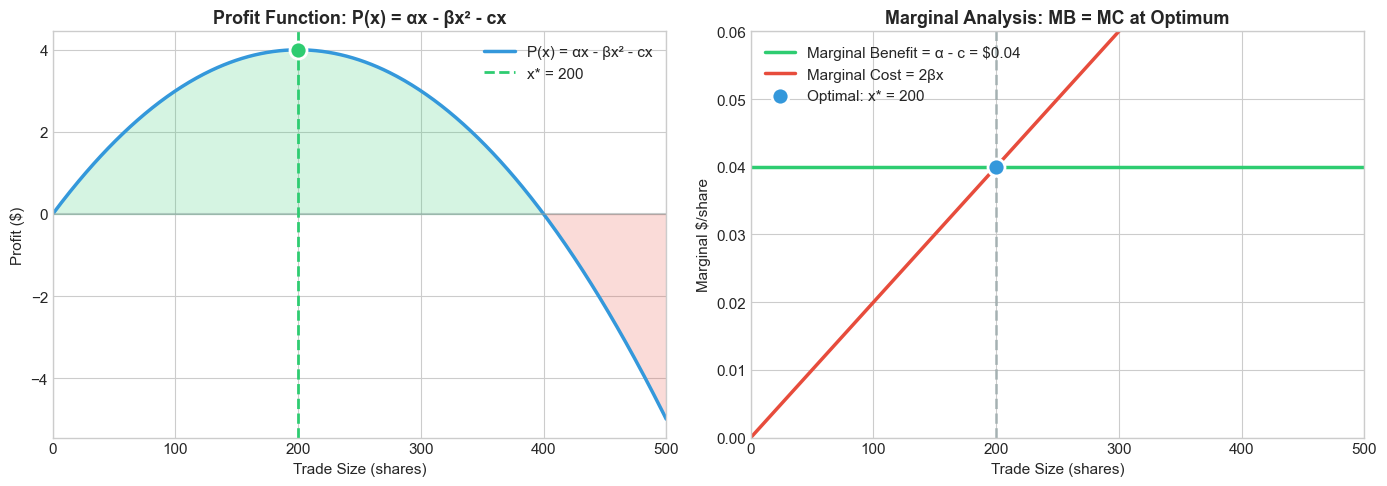


Key Insight: The optimal trade size occurs where marginal benefit equals marginal cost.
At x* = 200: MB = $0.0400, MC = $0.0400


In [4]:
# Visualize profit function
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Profit curve
x_range = np.linspace(0, 500, 500)
profits = profit_function(x_range, ALPHA, BETA, C)

axes[0].plot(x_range, profits, color=COLORS['secondary'], linewidth=2.5, label='P(x) = αx - βx² - cx')
axes[0].axhline(0, color=COLORS['neutral'], linestyle='-', alpha=0.5)
axes[0].axvline(base_result['optimal_size'], color=COLORS['primary'], linestyle='--', 
                linewidth=2, label=f"x* = {base_result['optimal_size']:.0f}")
axes[0].scatter([base_result['optimal_size']], [base_result['max_profit']], 
                color=COLORS['primary'], s=150, zorder=5, edgecolors='white', linewidth=2)
axes[0].fill_between(x_range, 0, profits, where=(profits > 0), alpha=0.2, color=COLORS['primary'])
axes[0].fill_between(x_range, 0, profits, where=(profits < 0), alpha=0.2, color=COLORS['accent'])

axes[0].set_xlabel('Trade Size (shares)')
axes[0].set_ylabel('Profit ($)')
axes[0].set_title('Profit Function: P(x) = αx - βx² - cx', fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].set_xlim(0, 500)

# Right: Marginal analysis
marginal_benefit = np.full_like(x_range, ALPHA - C)  # α - c (constant)
marginal_cost = 2 * BETA * x_range  # 2βx

axes[1].plot(x_range, marginal_benefit, color=COLORS['primary'], linewidth=2.5, 
             label=f'Marginal Benefit = α - c = ${ALPHA - C:.2f}')
axes[1].plot(x_range, marginal_cost, color=COLORS['accent'], linewidth=2.5,
             label='Marginal Cost = 2βx')
axes[1].axvline(base_result['optimal_size'], color=COLORS['neutral'], linestyle='--', 
                linewidth=2, alpha=0.7)
axes[1].scatter([base_result['optimal_size']], [2 * BETA * base_result['optimal_size']], 
                color=COLORS['secondary'], s=150, zorder=5, edgecolors='white', linewidth=2,
                label=f"Optimal: x* = {base_result['optimal_size']:.0f}")

axes[1].set_xlabel('Trade Size (shares)')
axes[1].set_ylabel('Marginal $/share')
axes[1].set_title('Marginal Analysis: MB = MC at Optimum', fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].set_xlim(0, 500)
axes[1].set_ylim(0, 0.06)

plt.tight_layout()
plt.show()

print("\nKey Insight: The optimal trade size occurs where marginal benefit equals marginal cost.")
print(f"At x* = {base_result['optimal_size']:.0f}: MB = ${ALPHA - C:.4f}, MC = ${2*BETA*base_result['optimal_size']:.4f}")

### Sensitivity Analysis

How does optimal trade size respond to changes in parameters?

From $x^* = \frac{\alpha - c}{2\beta}$:

- $\frac{\partial x^*}{\partial \alpha} = \frac{1}{2\beta} > 0$ (larger edge → larger size)
- $\frac{\partial x^*}{\partial \beta} = -\frac{\alpha - c}{2\beta^2} < 0$ (more impact → smaller size)
- $\frac{\partial x^*}{\partial c} = -\frac{1}{2\beta} < 0$ (higher costs → smaller size)

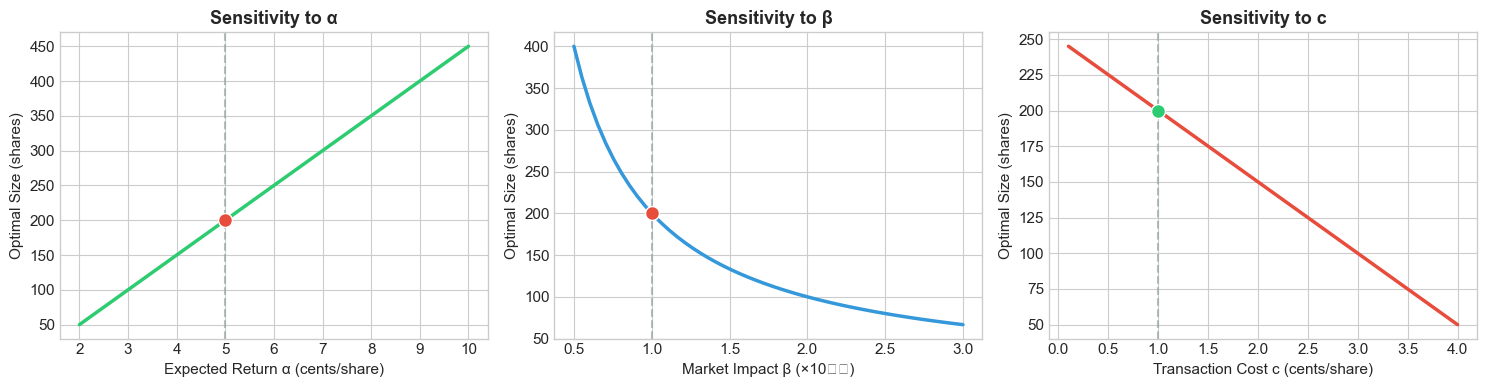

In [5]:
# Sensitivity analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Vary alpha
alphas = np.linspace(0.02, 0.10, 50)
x_opts_alpha = [optimal_trade_size(a, BETA, C) for a in alphas]
axes[0].plot(alphas * 100, x_opts_alpha, color=COLORS['primary'], linewidth=2.5)
axes[0].axvline(ALPHA * 100, color=COLORS['neutral'], linestyle='--', alpha=0.7)
axes[0].scatter([ALPHA * 100], [base_result['optimal_size']], color=COLORS['accent'], 
                s=100, zorder=5, edgecolors='white')
axes[0].set_xlabel('Expected Return α (cents/share)')
axes[0].set_ylabel('Optimal Size (shares)')
axes[0].set_title('Sensitivity to α', fontweight='bold')

# Vary beta
betas = np.linspace(0.00005, 0.0003, 50)
x_opts_beta = [optimal_trade_size(ALPHA, b, C) for b in betas]
axes[1].plot(betas * 10000, x_opts_beta, color=COLORS['secondary'], linewidth=2.5)
axes[1].axvline(BETA * 10000, color=COLORS['neutral'], linestyle='--', alpha=0.7)
axes[1].scatter([BETA * 10000], [base_result['optimal_size']], color=COLORS['accent'], 
                s=100, zorder=5, edgecolors='white')
axes[1].set_xlabel('Market Impact β (×10⁻⁴)')
axes[1].set_ylabel('Optimal Size (shares)')
axes[1].set_title('Sensitivity to β', fontweight='bold')

# Vary c
costs = np.linspace(0.001, 0.04, 50)
x_opts_c = [optimal_trade_size(ALPHA, BETA, cc) for cc in costs]
axes[2].plot(costs * 100, x_opts_c, color=COLORS['accent'], linewidth=2.5)
axes[2].axvline(C * 100, color=COLORS['neutral'], linestyle='--', alpha=0.7)
axes[2].scatter([C * 100], [base_result['optimal_size']], color=COLORS['primary'], 
                s=100, zorder=5, edgecolors='white')
axes[2].set_xlabel('Transaction Cost c (cents/share)')
axes[2].set_ylabel('Optimal Size (shares)')
axes[2].set_title('Sensitivity to c', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Leverage Optimization (Kelly Criterion)

### The Problem

You have capital and can use leverage $\ell$ (where $\ell = 1$ means no leverage, $\ell = 2$ means 2x leverage). The trade-off:

- **Return scales linearly**: Expected return is $\ell\mu$
- **Risk scales quadratically**: Variance is $\ell^2\sigma^2$

The risk-adjusted return function:

$$R(\ell) = \underbrace{\ell\mu}_{\text{expected return}} - \underbrace{\frac{1}{2}\ell^2\sigma^2}_{\text{risk penalty}}$$

The $\frac{1}{2}$ comes from the Taylor expansion of log utility, making this the **Kelly Criterion**.

### Deriving Optimal Leverage

$$R'(\ell) = \mu - \ell\sigma^2 = 0$$

$$\ell^* = \frac{\mu}{\sigma^2}$$

This is the famous **Kelly fraction**: optimal leverage equals Sharpe ratio divided by volatility.

In [6]:
def risk_adjusted_return(ell, mu, sigma):
    """
    Compute risk-adjusted return for given leverage.
    
    R(ℓ) = ℓμ - (1/2)ℓ²σ²
    
    Args:
        ell: Leverage multiple
        mu: Expected return (annualized)
        sigma: Volatility (annualized)
    
    Returns:
        Risk-adjusted return
    """
    return ell * mu - 0.5 * (ell ** 2) * (sigma ** 2)


def kelly_leverage(mu, sigma):
    """
    Compute optimal Kelly leverage.
    
    ℓ* = μ / σ²
    """
    return mu / (sigma ** 2)


def analyze_leverage(mu, sigma, name=""):
    """
    Complete analysis of leverage optimization.
    """
    ell_opt = kelly_leverage(mu, sigma)
    r_opt = risk_adjusted_return(ell_opt, mu, sigma)
    sharpe = mu / sigma
    
    # Break-even leverage (where R(ℓ) = 0)
    # ℓμ - (1/2)ℓ²σ² = 0 => ℓ(μ - (1/2)ℓσ²) = 0
    ell_breakeven = 2 * mu / (sigma ** 2)
    
    return {
        'name': name,
        'optimal_leverage': ell_opt,
        'max_risk_adj_return': r_opt,
        'sharpe_ratio': sharpe,
        'breakeven_leverage': ell_breakeven,
    }

In [7]:
# Market parameters
MU = 0.08        # 8% expected annual return
SIGMA = 0.20     # 20% annual volatility

# Analyze
kelly_result = analyze_leverage(MU, SIGMA, "Base Case")

print("=" * 60)
print("LEVERAGE OPTIMIZATION (KELLY CRITERION)")
print("=" * 60)
print(f"\nParameters:")
print(f"  μ (expected return):  {MU*100:.1f}%")
print(f"  σ (volatility):       {SIGMA*100:.1f}%")
print(f"  Sharpe ratio:         {kelly_result['sharpe_ratio']:.2f}")
print(f"\nOptimal Solution:")
print(f"  ℓ* = μ / σ²")
print(f"  ℓ* = {MU} / ({SIGMA})²")
print(f"  ℓ* = {MU} / {SIGMA**2}")
print(f"  ℓ* = {kelly_result['optimal_leverage']:.2f}x")
print(f"\nResults:")
print(f"  Max risk-adjusted return: {kelly_result['max_risk_adj_return']*100:.2f}%")
print(f"  Break-even leverage:      {kelly_result['breakeven_leverage']:.2f}x")
print(f"\nInterpretation:")
print(f"  With {MU*100:.0f}% expected return and {SIGMA*100:.0f}% volatility,")
print(f"  optimal leverage is {kelly_result['optimal_leverage']:.1f}x (borrow to double your position).")

LEVERAGE OPTIMIZATION (KELLY CRITERION)

Parameters:
  μ (expected return):  8.0%
  σ (volatility):       20.0%
  Sharpe ratio:         0.40

Optimal Solution:
  ℓ* = μ / σ²
  ℓ* = 0.08 / (0.2)²
  ℓ* = 0.08 / 0.04000000000000001
  ℓ* = 2.00x

Results:
  Max risk-adjusted return: 8.00%
  Break-even leverage:      4.00x

Interpretation:
  With 8% expected return and 20% volatility,
  optimal leverage is 2.0x (borrow to double your position).


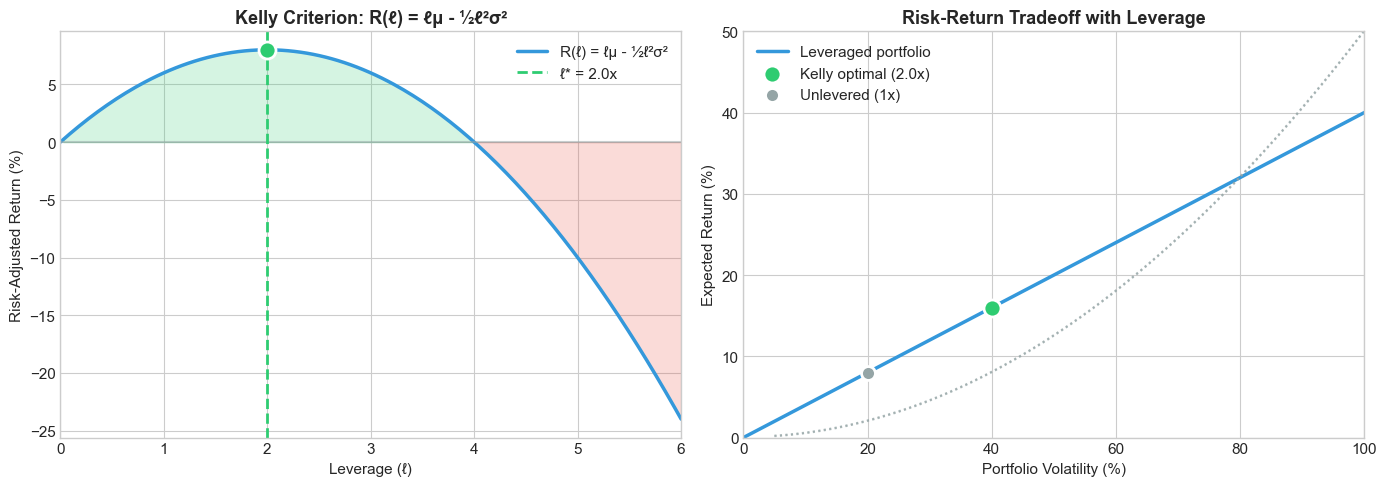

In [8]:
# Visualize leverage optimization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Risk-adjusted return curve
ell_range = np.linspace(0, 6, 200)
returns = risk_adjusted_return(ell_range, MU, SIGMA) * 100

axes[0].plot(ell_range, returns, color=COLORS['secondary'], linewidth=2.5, 
             label='R(ℓ) = ℓμ - ½ℓ²σ²')
axes[0].axhline(0, color=COLORS['neutral'], linestyle='-', alpha=0.5)
axes[0].axvline(kelly_result['optimal_leverage'], color=COLORS['primary'], linestyle='--', 
                linewidth=2, label=f"ℓ* = {kelly_result['optimal_leverage']:.1f}x")
axes[0].scatter([kelly_result['optimal_leverage']], [kelly_result['max_risk_adj_return']*100], 
                color=COLORS['primary'], s=150, zorder=5, edgecolors='white', linewidth=2)
axes[0].fill_between(ell_range, 0, returns, where=(returns > 0), alpha=0.2, color=COLORS['primary'])
axes[0].fill_between(ell_range, 0, returns, where=(returns < 0), alpha=0.2, color=COLORS['accent'])

axes[0].set_xlabel('Leverage (ℓ)')
axes[0].set_ylabel('Risk-Adjusted Return (%)')
axes[0].set_title('Kelly Criterion: R(ℓ) = ℓμ - ½ℓ²σ²', fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].set_xlim(0, 6)

# Right: Return vs Risk tradeoff
expected_returns = ell_range * MU * 100
volatilities = ell_range * SIGMA * 100

axes[1].plot(volatilities, expected_returns, color=COLORS['secondary'], linewidth=2.5,
             label='Leveraged portfolio')
axes[1].scatter([kelly_result['optimal_leverage'] * SIGMA * 100], 
                [kelly_result['optimal_leverage'] * MU * 100],
                color=COLORS['primary'], s=150, zorder=5, edgecolors='white', linewidth=2,
                label=f"Kelly optimal ({kelly_result['optimal_leverage']:.1f}x)")
axes[1].scatter([SIGMA * 100], [MU * 100], color=COLORS['neutral'], s=100, zorder=5,
                edgecolors='white', linewidth=2, label='Unlevered (1x)')

# Add iso-utility curves
for u in [0.04, 0.08, 0.12]:
    vol_curve = np.linspace(5, 100, 100)
    ret_curve = u + 0.5 * (vol_curve/100)**2 * 100  # Inverted from R = μℓ - ½σ²ℓ²
    axes[1].plot(vol_curve, ret_curve, color=COLORS['neutral'], linestyle=':', alpha=0.5)

axes[1].set_xlabel('Portfolio Volatility (%)')
axes[1].set_ylabel('Expected Return (%)')
axes[1].set_title('Risk-Return Tradeoff with Leverage', fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 50)

plt.tight_layout()
plt.show()

In [9]:
# Compare different volatility regimes
volatilities = [0.10, 0.15, 0.20, 0.25, 0.30, 0.40]
vol_results = []

for sigma in volatilities:
    result = analyze_leverage(MU, sigma)
    vol_results.append({
        'Volatility (%)': sigma * 100,
        'Kelly Leverage': result['optimal_leverage'],
        'Risk-Adj Return (%)': result['max_risk_adj_return'] * 100,
        'Sharpe Ratio': result['sharpe_ratio'],
    })

print("\nKelly Leverage Across Volatility Regimes (μ = 8%):")
print("=" * 65)
print(f"{'Volatility':>12} {'Kelly ℓ*':>12} {'Risk-Adj R':>14} {'Sharpe':>10}")
print("-" * 65)
for r in vol_results:
    print(f"{r['Volatility (%)']:>10.0f}% {r['Kelly Leverage']:>12.2f}x {r['Risk-Adj Return (%)']:>12.2f}% {r['Sharpe Ratio']:>10.2f}")

print("\nKey Insight: As volatility increases, optimal leverage decreases rapidly.")
print(f"At σ = 40%, Kelly says use only {vol_results[-1]['Kelly Leverage']:.2f}x leverage (half your capital!)")


Kelly Leverage Across Volatility Regimes (μ = 8%):
  Volatility     Kelly ℓ*     Risk-Adj R     Sharpe
-----------------------------------------------------------------
        10%         8.00x        32.00%       0.80
        15%         3.56x        14.22%       0.53
        20%         2.00x         8.00%       0.40
        25%         1.28x         5.12%       0.32
        30%         0.89x         3.56%       0.27
        40%         0.50x         2.00%       0.20

Key Insight: As volatility increases, optimal leverage decreases rapidly.
At σ = 40%, Kelly says use only 0.50x leverage (half your capital!)


## 4. Execution Time Optimization

### The Problem

You need to execute a trade and must choose how long to spread it over:

- **Execute fast**: High slippage from market impact ($k/t$)
- **Execute slow**: Price drifts away from your target ($\lambda t$)

The total cost function:

$$C(t) = \underbrace{\frac{k}{t}}_{\text{slippage}} + \underbrace{\lambda t}_{\text{opportunity cost}}$$

### Deriving Optimal Execution Time

$$C'(t) = -\frac{k}{t^2} + \lambda = 0$$

$$t^* = \sqrt{\frac{k}{\lambda}}$$

The second derivative confirms this is a minimum:

$$C''(t) = \frac{2k}{t^3} > 0 \quad \text{(convex)}$$

In [10]:
def execution_cost(t, k, lam):
    """
    Compute total execution cost.
    
    C(t) = k/t + λt
    
    Args:
        t: Execution time (minutes)
        k: Slippage intensity parameter
        lam: Opportunity cost rate (price drift per minute)
    
    Returns:
        Total cost
    """
    return k / t + lam * t


def optimal_execution_time(k, lam):
    """
    Compute optimal execution time analytically.
    
    t* = √(k/λ)
    """
    return np.sqrt(k / lam)


def analyze_execution(k, lam, name=""):
    """
    Complete analysis of execution time optimization.
    """
    t_opt = optimal_execution_time(k, lam)
    c_opt = execution_cost(t_opt, k, lam)
    
    # At optimum, slippage = opportunity cost
    slippage_at_opt = k / t_opt
    opp_cost_at_opt = lam * t_opt
    
    return {
        'name': name,
        'optimal_time': t_opt,
        'min_cost': c_opt,
        'slippage_at_opt': slippage_at_opt,
        'opp_cost_at_opt': opp_cost_at_opt,
    }

In [11]:
# Execution parameters
K = 1000      # Slippage intensity
LAMBDA = 2    # Opportunity cost rate

# Analyze
exec_result = analyze_execution(K, LAMBDA, "Base Case")

print("=" * 60)
print("EXECUTION TIME OPTIMIZATION")
print("=" * 60)
print(f"\nParameters:")
print(f"  k (slippage intensity):    {K}")
print(f"  λ (opportunity cost rate): {LAMBDA}")
print(f"\nOptimal Solution:")
print(f"  t* = √(k/λ)")
print(f"  t* = √({K}/{LAMBDA})")
print(f"  t* = √{K/LAMBDA}")
print(f"  t* = {exec_result['optimal_time']:.2f} minutes")
print(f"\nResults:")
print(f"  Minimum total cost:     ${exec_result['min_cost']:.2f}")
print(f"  Slippage component:     ${exec_result['slippage_at_opt']:.2f}")
print(f"  Opportunity cost:       ${exec_result['opp_cost_at_opt']:.2f}")
print(f"\nVerification:")
print(f"  At optimum, slippage = opportunity cost (both ≈ ${exec_result['slippage_at_opt']:.2f})")

EXECUTION TIME OPTIMIZATION

Parameters:
  k (slippage intensity):    1000
  λ (opportunity cost rate): 2

Optimal Solution:
  t* = √(k/λ)
  t* = √(1000/2)
  t* = √500.0
  t* = 22.36 minutes

Results:
  Minimum total cost:     $89.44
  Slippage component:     $44.72
  Opportunity cost:       $44.72

Verification:
  At optimum, slippage = opportunity cost (both ≈ $44.72)


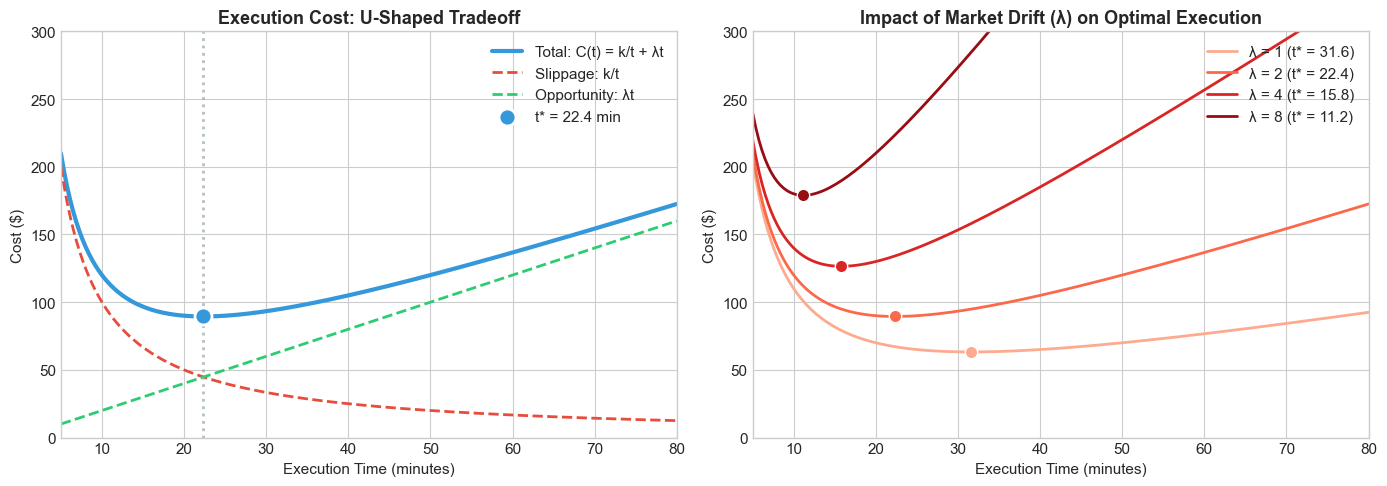


Key Insight: As market drift (λ) increases, optimal execution time decreases.
In volatile/trending markets, execute faster to avoid adverse price movement.


In [12]:
# Visualize execution cost
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Total cost curve (U-shaped)
t_range = np.linspace(5, 80, 200)
total_costs = execution_cost(t_range, K, LAMBDA)
slippage_costs = K / t_range
opp_costs = LAMBDA * t_range

axes[0].plot(t_range, total_costs, color=COLORS['secondary'], linewidth=3, label='Total: C(t) = k/t + λt')
axes[0].plot(t_range, slippage_costs, color=COLORS['accent'], linewidth=2, linestyle='--', label='Slippage: k/t')
axes[0].plot(t_range, opp_costs, color=COLORS['primary'], linewidth=2, linestyle='--', label='Opportunity: λt')
axes[0].axvline(exec_result['optimal_time'], color=COLORS['neutral'], linestyle=':', linewidth=2, alpha=0.7)
axes[0].scatter([exec_result['optimal_time']], [exec_result['min_cost']], 
                color=COLORS['secondary'], s=150, zorder=5, edgecolors='white', linewidth=2,
                label=f"t* = {exec_result['optimal_time']:.1f} min")

axes[0].set_xlabel('Execution Time (minutes)')
axes[0].set_ylabel('Cost ($)')
axes[0].set_title('Execution Cost: U-Shaped Tradeoff', fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].set_xlim(5, 80)
axes[0].set_ylim(0, 300)

# Right: Different market conditions
lambdas = [1, 2, 4, 8]  # Different drift rates
colors_lambda = plt.cm.Reds(np.linspace(0.3, 0.9, len(lambdas)))

for lam, color in zip(lambdas, colors_lambda):
    costs = execution_cost(t_range, K, lam)
    t_opt = optimal_execution_time(K, lam)
    axes[1].plot(t_range, costs, color=color, linewidth=2, label=f'λ = {lam} (t* = {t_opt:.1f})')
    axes[1].scatter([t_opt], [execution_cost(t_opt, K, lam)], color=color, s=80, zorder=5, edgecolors='white')

axes[1].set_xlabel('Execution Time (minutes)')
axes[1].set_ylabel('Cost ($)')
axes[1].set_title('Impact of Market Drift (λ) on Optimal Execution', fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].set_xlim(5, 80)
axes[1].set_ylim(0, 300)

plt.tight_layout()
plt.show()

print("\nKey Insight: As market drift (λ) increases, optimal execution time decreases.")
print("In volatile/trending markets, execute faster to avoid adverse price movement.")

## 5. Unified Framework: The Common Structure

All three problems share a fundamental structure:

| Problem | Benefit Term | Cost Term | Optimal Solution |
|---------|--------------|-----------|------------------|
| Trade Size | $\alpha x$ (linear) | $\beta x^2$ (quadratic) | $x^* = \frac{\alpha - c}{2\beta}$ |
| Leverage | $\ell\mu$ (linear) | $\frac{1}{2}\ell^2\sigma^2$ (quadratic) | $\ell^* = \frac{\mu}{\sigma^2}$ |
| Execution | N/A | $\frac{k}{t} + \lambda t$ (convex) | $t^* = \sqrt{\frac{k}{\lambda}}$ |

**The Pattern**: Interior optima exist because benefits grow sublinearly (or costs grow superlinearly).

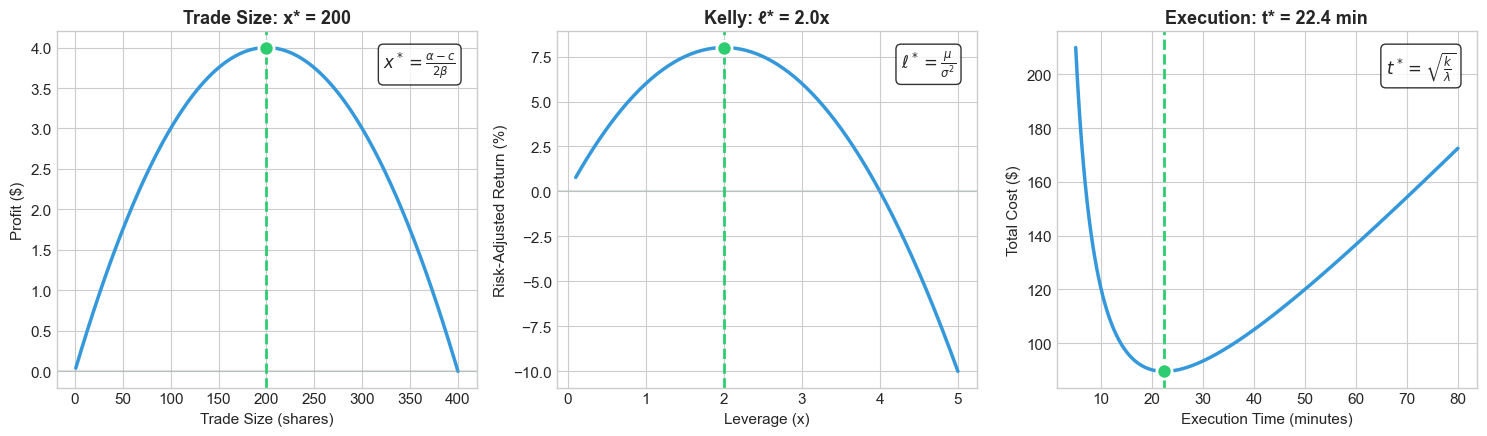

In [13]:
# Unified visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Panel 1: Trade Size
x_range = np.linspace(1, 400, 200)
profits = profit_function(x_range, ALPHA, BETA, C)
axes[0].plot(x_range, profits, color=COLORS['secondary'], linewidth=2.5)
axes[0].axhline(0, color=COLORS['neutral'], linestyle='-', alpha=0.3)
axes[0].axvline(base_result['optimal_size'], color=COLORS['primary'], linestyle='--', linewidth=2)
axes[0].scatter([base_result['optimal_size']], [base_result['max_profit']], 
                color=COLORS['primary'], s=120, zorder=5, edgecolors='white', linewidth=2)
axes[0].set_xlabel('Trade Size (shares)')
axes[0].set_ylabel('Profit ($)')
axes[0].set_title(f"Trade Size: x* = {base_result['optimal_size']:.0f}", fontweight='bold')
axes[0].text(0.95, 0.95, r'$x^* = \frac{\alpha - c}{2\beta}$', transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel 2: Leverage
ell_range = np.linspace(0.1, 5, 200)
returns = risk_adjusted_return(ell_range, MU, SIGMA) * 100
axes[1].plot(ell_range, returns, color=COLORS['secondary'], linewidth=2.5)
axes[1].axhline(0, color=COLORS['neutral'], linestyle='-', alpha=0.3)
axes[1].axvline(kelly_result['optimal_leverage'], color=COLORS['primary'], linestyle='--', linewidth=2)
axes[1].scatter([kelly_result['optimal_leverage']], [kelly_result['max_risk_adj_return']*100], 
                color=COLORS['primary'], s=120, zorder=5, edgecolors='white', linewidth=2)
axes[1].set_xlabel('Leverage (x)')
axes[1].set_ylabel('Risk-Adjusted Return (%)')
axes[1].set_title(f"Kelly: ℓ* = {kelly_result['optimal_leverage']:.1f}x", fontweight='bold')
axes[1].text(0.95, 0.95, r'$\ell^* = \frac{\mu}{\sigma^2}$', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel 3: Execution Time
t_range = np.linspace(5, 80, 200)
costs = execution_cost(t_range, K, LAMBDA)
axes[2].plot(t_range, costs, color=COLORS['secondary'], linewidth=2.5)
axes[2].axvline(exec_result['optimal_time'], color=COLORS['primary'], linestyle='--', linewidth=2)
axes[2].scatter([exec_result['optimal_time']], [exec_result['min_cost']], 
                color=COLORS['primary'], s=120, zorder=5, edgecolors='white', linewidth=2)
axes[2].set_xlabel('Execution Time (minutes)')
axes[2].set_ylabel('Total Cost ($)')
axes[2].set_title(f"Execution: t* = {exec_result['optimal_time']:.1f} min", fontweight='bold')
axes[2].text(0.95, 0.95, r'$t^* = \sqrt{\frac{k}{\lambda}}$', transform=axes[2].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [14]:
# Summary table
print("=" * 75)
print("OPTIMAL TRADE DESIGN: SUMMARY")
print("=" * 75)
print(f"\n{'Problem':<20} {'Formula':<25} {'Optimal Value':<20}")
print("-" * 75)
print(f"{'Trade Size':<20} {'x* = (α-c)/(2β)':<25} {base_result['optimal_size']:.0f} shares")
print(f"{'Leverage (Kelly)':<20} {'ℓ* = μ/σ²':<25} {kelly_result['optimal_leverage']:.2f}x")
print(f"{'Execution Time':<20} {'t* = √(k/λ)':<25} {exec_result['optimal_time']:.1f} minutes")
print("\n" + "=" * 75)
print("KEY INSIGHT: All three have interior optima because one force diminishes")
print("while another accelerates. Calculus finds where they balance.")
print("=" * 75)

OPTIMAL TRADE DESIGN: SUMMARY

Problem              Formula                   Optimal Value       
---------------------------------------------------------------------------
Trade Size           x* = (α-c)/(2β)           200 shares
Leverage (Kelly)     ℓ* = μ/σ²                 2.00x
Execution Time       t* = √(k/λ)               22.4 minutes

KEY INSIGHT: All three have interior optima because one force diminishes
while another accelerates. Calculus finds where they balance.


## 6. Extensions and Real-World Considerations

### What We Simplified

1. **Trade Size**: Real market impact is more complex (temporary vs permanent, nonlinear)
2. **Leverage**: Kelly assumes known parameters; practitioners use fractional Kelly (½ or ¼)
3. **Execution**: Real algorithms use dynamic programming with stochastic prices

### What We Captured

1. **The core tradeoff structure**: Benefits vs. accelerating costs
2. **Closed-form intuition**: Understanding how parameters affect decisions
3. **Marginal analysis**: Optimal occurs where marginal benefit = marginal cost

### Industry Applications

- **Market makers**: Size positions using impact models
- **Hedge funds**: Set leverage using Kelly-type frameworks
- **Execution algorithms**: TWAP, VWAP, and IS algorithms balance slippage vs. drift

In [15]:
# Fractional Kelly demonstration
fractions = [0.25, 0.5, 0.75, 1.0]
full_kelly = kelly_result['optimal_leverage']

print("Fractional Kelly Analysis:")
print("=" * 60)
print(f"Full Kelly leverage: {full_kelly:.2f}x")
print(f"\n{'Fraction':<12} {'Leverage':<12} {'E[Return]':<15} {'Volatility':<12}")
print("-" * 60)

for f in fractions:
    ell = f * full_kelly
    ret = ell * MU * 100
    vol = ell * SIGMA * 100
    print(f"{f:<12.0%} {ell:<12.2f}x {ret:<14.1f}% {vol:<12.1f}%")

print("\nPractitioners often use ½ Kelly for robustness to estimation error.")

Fractional Kelly Analysis:
Full Kelly leverage: 2.00x

Fraction     Leverage     E[Return]       Volatility  
------------------------------------------------------------
25%          0.50        x 4.0           % 10.0        %
50%          1.00        x 8.0           % 20.0        %
75%          1.50        x 12.0          % 30.0        %
100%         2.00        x 16.0          % 40.0        %

Practitioners often use ½ Kelly for robustness to estimation error.


## 7. Conclusion

This notebook demonstrated how single-variable calculus solves fundamental trading problems:

1. **Trade Size**: $x^* = \frac{\alpha - c}{2\beta}$ balances return against market impact
2. **Leverage**: $\ell^* = \frac{\mu}{\sigma^2}$ balances return against risk (Kelly Criterion)
3. **Execution**: $t^* = \sqrt{\frac{k}{\lambda}}$ balances slippage against opportunity cost

### The Unifying Principle

**Interior optima exist when benefits show diminishing returns while costs accelerate.** This principle appears throughout quantitative finance:

- Portfolio optimization (return vs. variance)
- Option pricing (hedging costs vs. replication error)
- Market making (spread vs. inventory risk)
